# Data Cleaning, Feature Engineering Notebook

In [237]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from scipy.spatial.distance import correlation, cosine
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('scotus_rulings.csv', index_col=0)

## Clean data and engineer metric
As seen by the sample rows, a justice can hold multiple opinions on a case.  They can simultaneously agree with the decision of the majority opinion but hold a separate reasoning(s) on the ruling (filing a concurrence).  With 1 being agreement and 2 filing a concurrence (and similarly 4 being dissent and 3 filing a concurrence/dissent).  The metric used here tries to capture the difference between those opinions by finding the mean of a justice's opinion (while removing filing multiple concurrences/dissents in a specific case).

In [3]:
# Map code string to metric function
def string_2_ints(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers, simplify to either majority or dissent
    nums = []
    for x in set(list(s)):
        try:
            nums.append(int(x))
        except:
            continue
    
    return np.mean(nums)

In [61]:
adj_df = pd.DataFrame(np.vectorize(string_2_ints)(df), index=df.index, columns=df.columns)

In [286]:
class scotus_rulings(object):
    def __init__(self, df):
        self.df = df
        self.justices = list(df.index)
        
    def __len__(self):
        return len(self.df.columns)
    
    def __str__(self):
        return f'Justices: {len(self.justices)}\nCases: {len(self.df.columns)}'
        
    def justice_term(self, justice):
        '''
        Cosine similarity of a justice
        '''
        
        assert justice in self.justices, f'Not a justice between 1999-2019.\nChoose one of {self.justices}'
        js = list(self.justices)
        js.remove(justice)
        
        # Create dictionary {justice: cosine similarity}
        no_sim = []
        sim = {}
        for j in js:
            anb = np.where(self.df.loc[justice].notna() & self.df.loc[j].notna(), self.df.columns, np.nan)
            if len([ x for x in anb if str(x) != 'nan' ]) != 0:
                j_a = self.df[[ x for x in anb if str(x) != 'nan' ]].loc[justice]
                j_b = self.df[[ x for x in anb if str(x) != 'nan' ]].loc[j]
                sim[j] = round(1 - cosine(j_a, j_b), 4)
            else:
                no_sim.append(j)
        
        # Print results
        sim = { k: v for k, v in sorted(sim.items(), key=lambda item: item[1], reverse=True) }
        ordered = list(sim.keys())
        print(f'Justice {justice} Cosine Similarity: (descending similarity)')
        print(20*'-')
        for j in ordered:
            print(f'{j}:', sim[j])
            if j == ordered[-1]:
                print(20*'-')
        if len(no_sim) > 0:
            print('No rulings with:')
            print(20*'-')
            for j in no_sim:
                print(f'{j}')
                
    def sim_matrix(self):
        '''
        Return cosine similarity matrix
        '''
        
        jus = list(self.justices)
        l = len(jus)
        self.sim_mat = np.zeros((l,l))
        
        for i in range(l):
            for j in range(l):   
                anb = np.where(self.df.loc[jus[i]].notna() & self.df.loc[jus[j]].notna(), self.df.columns, np.nan)
                if len([ x for x in anb if str(x) != 'nan' ]) != 0:
                    j_a = self.df[[ x for x in anb if str(x) != 'nan' ]].loc[jus[i]]
                    j_b = self.df[[ x for x in anb if str(x) != 'nan' ]].loc[jus[j]]
                    self.sim_mat[i][j] = round(1 - cosine(j_a, j_b), 4)
                else:
                    self.sim_mat[i][j] = np.nan
            
        del jus
        del l
        return self.sim_mat                     

In [287]:
rulings = scotus_rulings(adj_df)

In [288]:
sim_mat = pd.DataFrame(rulings.sim_matrix(), index=adj_df.index, columns=adj_df.index)

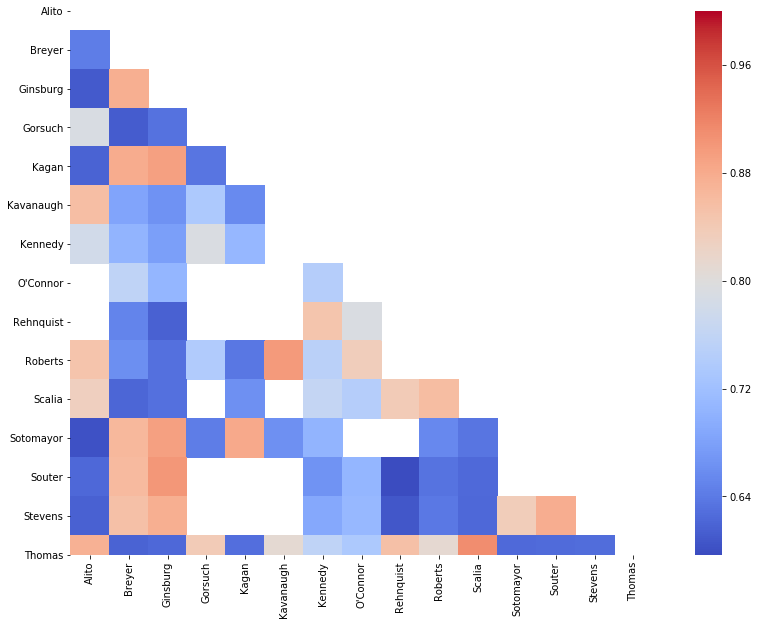

In [294]:
plt.figure(figsize=(15,10))
mask = np.zeros(sim_mat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(sim_mat, cmap='coolwarm', mask=mask, square=True)
plt.show()

In [5]:
current = adj_df.iloc[:, -117:].drop(['Kennedy', "O'Connor", 'Rehnquist', 'Scalia', 'Souter', 'Stevens']).dropna(axis=1)

In [8]:
X = current.values

In [9]:
print('Explained Variance:')
print('-------------------')
for n in range(1, 10):
    pca = PCA(n_components=n)
    pca.fit_transform(X)
    print(f'{n} components:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Explained Variance:
-------------------
1 components: 52.8
2 components: 69.2
3 components: 80.03
4 components: 85.83
5 components: 90.6
6 components: 94.81
7 components: 98.0
8 components: 100.0
9 components: 100.0


In [14]:
pca = PCA(n_components=3)
comps = pd.DataFrame(pca.fit_transform(X), index=current.index)

In [15]:
comps

,0,1,2
Alito,9.642828,-1.827207,-3.781748
Breyer,-7.898764,-2.551288,-2.697548
Ginsburg,-8.747425,1.365728,-1.515708
Gorsuch,4.934267,7.376875,6.444388
Kagan,-7.506348,0.124858,-0.054139
Kavanaugh,4.825547,-5.271002,2.846693
Roberts,4.695101,-6.466081,2.992429
Sotomayor,-9.440348,2.063625,0.944497
Thomas,9.495141,5.184492,-5.178864


In [295]:
fig = px.scatter_3d(comps, x=0, y=1, z=2, text=comps.index, range_x=(-12,12), range_y=(-9,9), range_z=(-8,8))
fig.show()